# Import

In [34]:
%pip install seaborn scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import (roc_auc_score, f1_score, precision_score, 
                             recall_score, confusion_matrix, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# Load/Split

In [36]:
file_path = './dataset.csv'
df = pd.read_csv(file_path, sep=',')

# Priprema i analiza podataka

## Opis podataka

- $id$
- $track\_id$ - jedinstveni id pesme
- $artists$ - izvođači, razdvojeni ';'
- $album\_name$ - ime albuma
- $track\_namet$ - ime pesme
- $popularity$ - vrednost od 0 do 100, bazirana na tome koliko često je pesma puštana na Spotify-u u skorije vreme
- $duration\_ms$ - trajanje pesme u ms
- $explicit$ - da li pesma sadrži eksplicitan tekst
- $danceability$ - koliko je pesma "plesljiva" - od 0 do 1
- $energy$ - koliko je pesma energična (0 do 1), određena na osnovu više odlika pesme (brzina, koliko je pesma glasna...)
- $key$ - u kojoj lestvici je pesma
- $loudness$ - koliko je pesma glasna u dB
- $mode$ - da li je dur ili mol lestvica (1 - dur, 0 - mol)
- $speechiness$ - koliko je zastupljen tekst u pesmi - 0 do 1
- $acousticness$ - verovatnoća da je pesma akustična - 0 do 1
- $instrumentalness$ - verovatnoća da je pesma instrumental - 0 do 1, 1 označava veliku verovatnoću da nema vokala u pesmi
- $liveness$ - verovatnoća da je pesma izvedena u javnosti (koncert) - 0 do 1
- $valence$ - koliko je pesma vesela - 1 predstavlja srećne pesme dok 0 su tužnije pesme
- $tempo$ - brzina pesme u bitovima po minutu
- $time\_signature$ - ritam, takt
- $track\_genre$ - žanr pesme, ciljni atribut

In [37]:
print(f"Broj ulaza u skupu podataka: {len(df)}")

Broj ulaza u skupu podataka: 114000


In [38]:
print(f"Broj ulaznih promenljivih u skupu podataka: {len(df.iloc[0])}")

Broj ulaznih promenljivih u skupu podataka: 21


- Ukupno imamo <span style="color:#03d3fc">20 ulazne promenljive</span> i <span style="color:#fc036f">1 ciljnu promenljivu</span>
- Ukupno imamo <span style="color:#03d3fc">114000 ulaza u skupu podataka</span>
- Koristimo 80-20 podelu za trening i test skup

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

- Nema nedostajućih vrednosti u skupu
- $track\_id$, $artists$, $album\_name$, $track\_name$, $track\_genre$ su object

## Obrada atributa

$track\_id$ atribut možemo da izbacimo kao i $Unnamed: 0$ koji predstavljaju samo identifikatore

In [40]:
df.drop(labels=['track_id','Unnamed: 0'],inplace=True, axis=1)

$artists$ atribut analiziramo

In [41]:
report = {
    'maximum_artists_on_single_track': 0,\
    'unique_artist_count':0,
    'longest_artist_list':'',
    'missing_artists_index':[]
}
artists= df['artists'].str.split(';')
unique_artists = []
for i,artist_list in enumerate(artists):
    try:
        if len(artist_list) > report['maximum_artists_on_single_track']:
            report['maximum_artists_on_single_track'] = len(artist_list)
            report['longest_artist_list'] = artist_list

        report['maximum_artists_on_single_track'] = max(report['maximum_artists_on_single_track'], len(artist_list))
        for artist in artist_list:
            if artist in unique_artists: continue
            unique_artists.append(artist)
    except:
        report['missing_artists_index'].append(i)
report['unique_artist_count'] = len(unique_artists)

In [42]:
report

{'maximum_artists_on_single_track': 38,
 'unique_artist_count': 29859,
 'longest_artist_list': ['Aitana',
  'Alejandro Sanz',
  'Antonio José',
  'Antonio Orozco',
  'Pablo López',
  'Alejandro Lerner',
  'Alessia Cara',
  'Alex Ubago',
  'Ana Mena',
  'Andrés Calamaro',
  'Andrés Dvicio',
  'Brian May',
  'Camilo',
  'Carlos Rivera',
  'David Bisbal',
  'Draco',
  'Dulce Pontes',
  'Fher',
  'India Martinez',
  'Joy',
  'Juanes',
  'Lali',
  'Laura Pausini',
  'Leire Martinez',
  'Macaco',
  'Malú',
  'Manolo Garcia',
  'Manuel Carrasco',
  'Mau y Ricky',
  'Melendi',
  'Miguel Ríos',
  'Mikel Izal',
  'NATHY PELUSO',
  'Pablo Alborán',
  'Rosario',
  'Rozalén',
  'Sebastian Yatra',
  'Vanesa Martín'],
 'missing_artists_index': [65900]}

- Pesma sa najviše izvođača ima 38 izvođača
- Postoji pesma bez ijednog izvođača - pesma sa indeksom 65900, koju izbacujemo
- Postoje 29859 jedinstvenih izvođača
- Moramo da zamenimo atribut artists nekim drugim atributom
    - Jedan izbor je da zamenimo brojem izvođača, pesme sa velikim brojem izvođača su najverovatnije retkost
    - Drugi izbor je da zamenimo sa indeksima izvođača, međutim to zahteva 38 dodatnih atributa u najgorem slučaju, a takođe bi loše funkcionisalo sa pojavom novih izvođača
    

In [43]:
print('Before: ', len(df))
df.drop(labels=report['missing_artists_index'], inplace=True, axis=0)
print('After: ', len(df))

Before:  114000
After:  113999


In [44]:
df['artists'] = df['artists'].str.split(';')
df['artists'] = df['artists'].apply(len)

In [45]:
df.describe()

artists     popularity   duration_ms   danceability  \
count  113999.000000  113999.000000  1.139990e+05  113999.000000   
mean        1.388538      33.238827  2.280312e+05       0.566801   
std         0.863545      22.304959  1.072961e+05       0.173543   
min         1.000000       0.000000  8.586000e+03       0.000000   
25%         1.000000      17.000000  1.740660e+05       0.456000   
50%         1.000000      35.000000  2.129060e+05       0.580000   
75%         2.000000      50.000000  2.615060e+05       0.695000   
max        38.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        0.641383       5.309126      -8.258950       0.637558   
std         0.251530       3.559999       5.029357       0.480708   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  113999.000000  113999.000000     113999.000000  113999.000000   
mean        0.084652       0.314907          0.156051       0.213554   
std         0.105733       0.332522          0.309556       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.597500          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  113999.000000  113999.000000   113999.000000  
mean        0.474066     122.147695        3.904034  
std         0.259261      29.978290        0.432623  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218500        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

- Kao što smo pretpostavili, većina pesama ima samo 1 izvođača, prosek je 1.388 izvođača po pesmi

Atribute $track\_name$ i $album\_name$ možemo takođe da zamenimo dužinom imena

In [46]:
df['track_name'] = df['track_name'].apply(len)
df['album_name'] = df['album_name'].apply(len)

Na kraju trebamo još da enkodiramo atribut za žanr

In [47]:
label_encoder = LabelEncoder()

df['track_genre'] = label_encoder.fit_transform(df['track_genre'])

In [48]:
df['explicit'] = df['explicit'].apply(int)

In [49]:
df.describe()

artists     album_name     track_name     popularity  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        1.388538      20.116668      17.994684      33.238827   
std         0.863545      13.711497      13.148281      22.304959   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000      11.000000       9.000000      17.000000   
50%         1.000000      17.000000      15.000000      35.000000   
75%         2.000000      26.000000      23.000000      50.000000   
max        38.000000     243.000000     511.000000     100.000000   

        duration_ms       explicit   danceability         energy  \
count  1.139990e+05  113999.000000  113999.000000  113999.000000   
mean   2.280312e+05       0.085501       0.566801       0.641383   
std    1.072961e+05       0.279627       0.173543       0.251530   
min    8.586000e+03       0.000000       0.000000       0.000000   
25%    1.740660e+05       0.000000       0.456000       0.472000   
50%    2.129060e+05       0.000000       0.580000       0.685000   
75%    2.615060e+05       0.000000       0.695000       0.854000   
max    5.237295e+06       1.000000       0.985000       1.000000   

                 key       loudness           mode    speechiness  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        5.309126      -8.258950       0.637558       0.084652   
std         3.559999       5.029357       0.480708       0.105733   
min         0.000000     -49.531000       0.000000       0.000000   
25%         2.000000     -10.013000       0.000000       0.035900   
50%         5.000000      -7.004000       1.000000       0.048900   
75%         8.000000      -5.003000       1.000000       0.084500   
max        11.000000       4.532000       1.000000       0.965000   

        acousticness  instrumentalness       liveness        valence  \
count  113999.000000     113999.000000  113999.000000  113999.000000   
mean        0.314907          0.156051       0.213554       0.474066   
std         0.332522          0.309556       0.190378       0.259261   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.016900          0.000000       0.098000       0.260000   
50%         0.169000          0.000042       0.132000       0.464000   
75%         0.597500          0.049000       0.273000       0.683000   
max         0.996000          1.000000       1.000000       0.995000   

               tempo  time_signature    track_genre  
count  113999.000000   113999.000000  113999.000000  
mean      122.147695        3.904034      56.499925  
std        29.978290        0.432623      32.907978  
min         0.000000        0.000000       0.000000  
25%        99.218500        4.000000      28.000000  
50%       122.017000        4.000000      56.000000  
75%       140.071000        4.000000      85.000000  
max       243.372000        5.000000     113.000000

In [50]:
#Menjamo tipove kako bi smanjili upotrebu memorije
df['duration_s'] = df['duration_ms'] / 1000 #prevodimo u sekunde
df.drop(['duration_ms'], inplace=True, axis=1)
for x in df.columns:
    if df[x][0].dtype == np.int64 or df[x][0].dtype==np.int32:
        df[x] = df[x].astype(np.int16)
    elif df[x][0].dtype == np.float64:
        df[x] = df[x].astype(np.float16)

In [51]:
df.describe()

c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site

artists     album_name     track_name     popularity  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        1.388538      20.116668      17.994684      33.238827   
std         0.863545      13.711497      13.148281      22.304959   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000      11.000000       9.000000      17.000000   
50%         1.000000      17.000000      15.000000      35.000000   
75%         2.000000      26.000000      23.000000      50.000000   
max        38.000000     243.000000     511.000000     100.000000   

            explicit   danceability         energy            key  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        0.085501       0.000000            NaN       5.309126   
std         0.279627       0.000000       0.000000       3.559999   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.456055       0.471924       2.000000   
50%         0.000000       0.580078       0.685059       5.000000   
75%         0.000000       0.694824       0.854004       8.000000   
max         1.000000       0.984863       1.000000      11.000000   

            loudness           mode    speechiness   acousticness  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean             NaN       0.637558       0.000000       0.000000   
std         0.000000       0.480708       0.000000       0.000000   
min       -49.531250       0.000000       0.000000       0.000000   
25%       -10.015625       0.000000       0.035889       0.016907   
50%        -7.003906       1.000000       0.048889       0.168945   
75%        -5.003906       1.000000       0.084473       0.597656   
max         4.531250       1.000000       0.964844       0.996094   

       instrumentalness       liveness        valence         tempo  \
count     113999.000000  113999.000000  113999.000000  113999.00000   
mean           0.000000       0.000000       0.000000           NaN   
std            0.000000       0.000000       0.000000       0.00000   
min            0.000000       0.000000       0.000000       0.00000   
25%            0.000000       0.098022       0.260010      99.21875   
50%            0.000042       0.131958       0.464111     122.00000   
75%            0.049011       0.272949       0.683105     140.12500   
max            1.000000       1.000000       0.995117     243.37500   

       time_signature    track_genre     duration_s  
count   113999.000000  113999.000000  113999.000000  
mean         3.904034      56.499925            NaN  
std          0.432623      32.907978            NaN  
min          0.000000       0.000000       8.585938  
25%          4.000000      28.000000     174.125000  
50%          4.000000      56.000000     212.875000  
75%          4.000000      85.000000     261.500000  
max          5.000000     113.000000    5236.000000

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113999 non-null  int16  
 1   album_name        113999 non-null  int16  
 2   track_name        113999 non-null  int16  
 3   popularity        113999 non-null  int16  
 4   explicit          113999 non-null  int16  
 5   danceability      113999 non-null  float16
 6   energy            113999 non-null  float16
 7   key               113999 non-null  int16  
 8   loudness          113999 non-null  float16
 9   mode              113999 non-null  int16  
 10  speechiness       113999 non-null  float16
 11  acousticness      113999 non-null  float16
 12  instrumentalness  113999 non-null  float16
 13  liveness          113999 non-null  float16
 14  valence           113999 non-null  float16
 15  tempo             113999 non-null  float16
 16  time_signature    113999 

In [53]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
for train_index, test_index in strat_split.split(df, df['track_genre']):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

## Raspodele podataka

<Figure size 640x480 with 0 Axes>

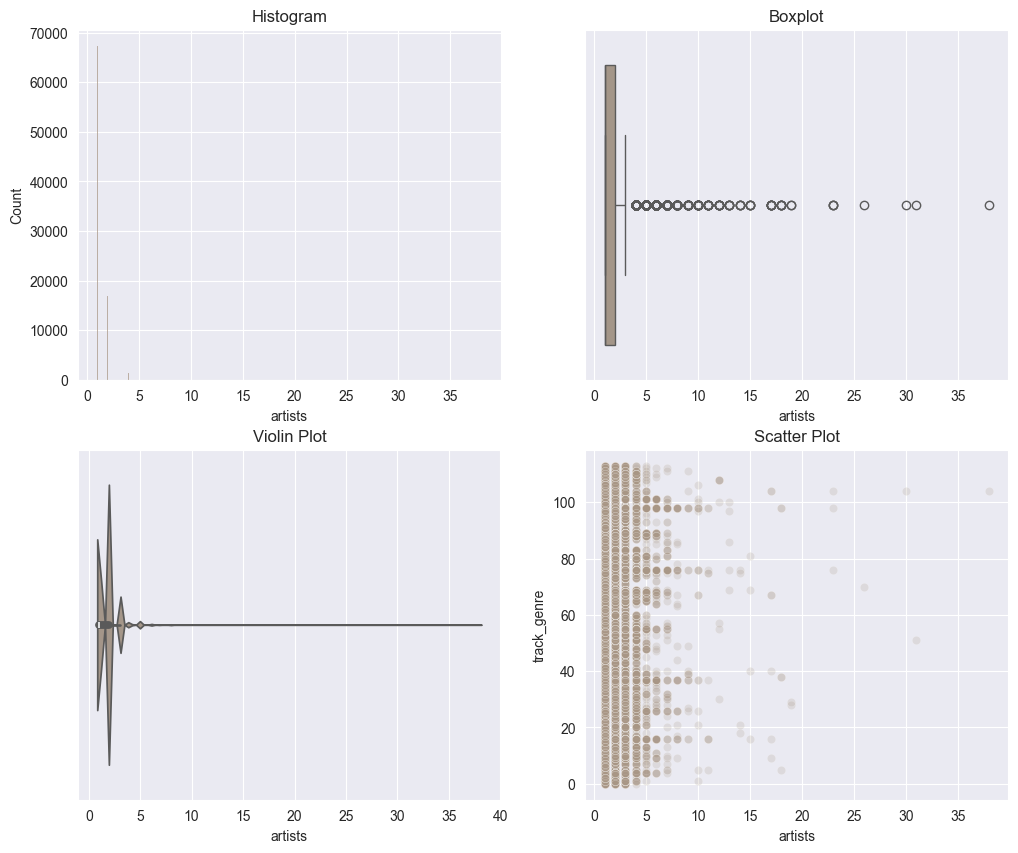

<Figure size 640x480 with 0 Axes>

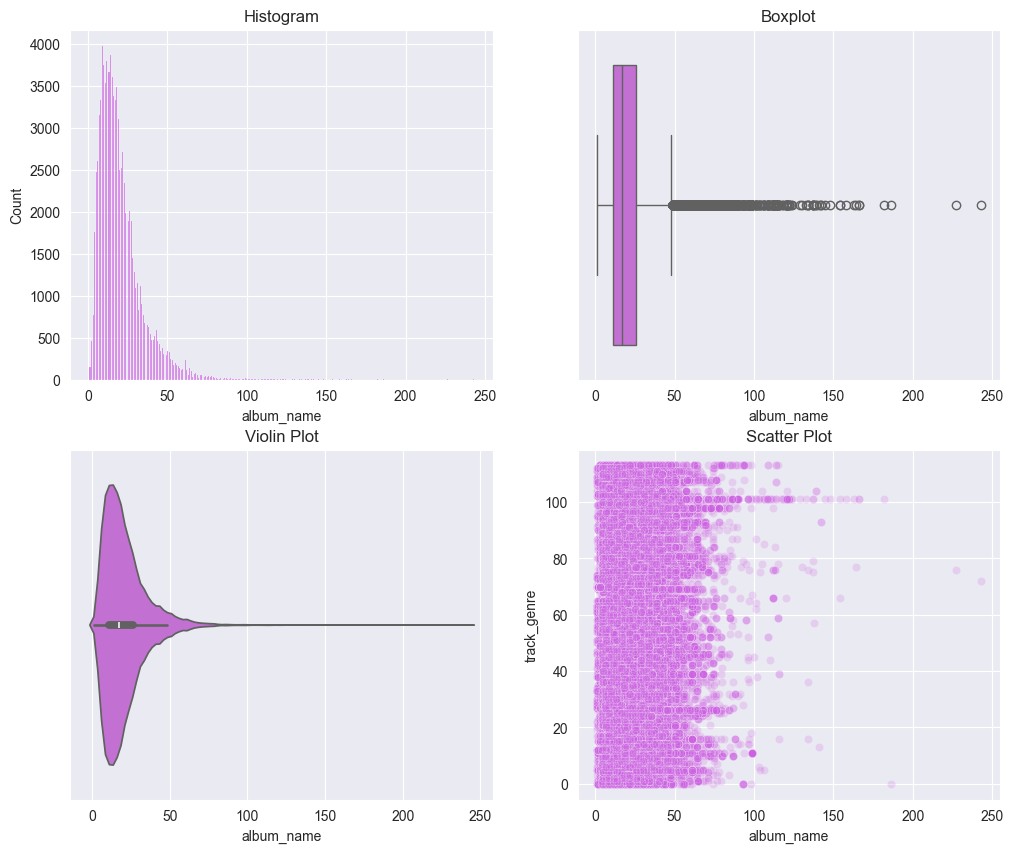

<Figure size 640x480 with 0 Axes>

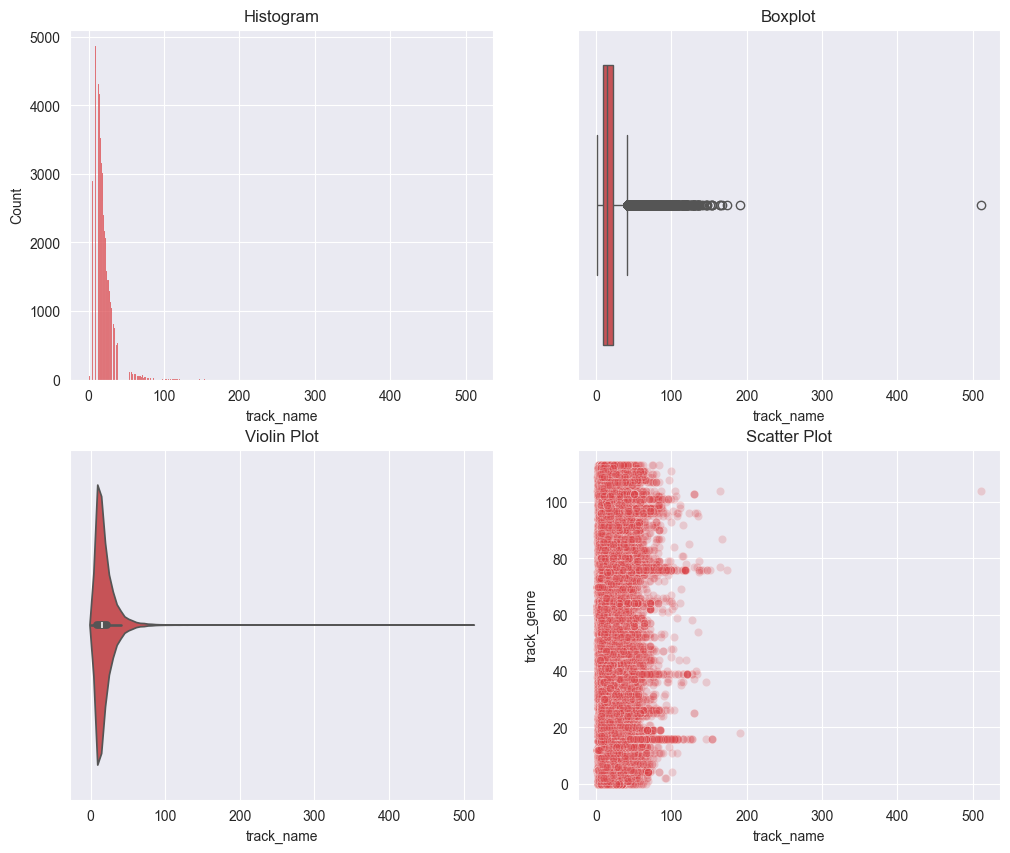

<Figure size 640x480 with 0 Axes>

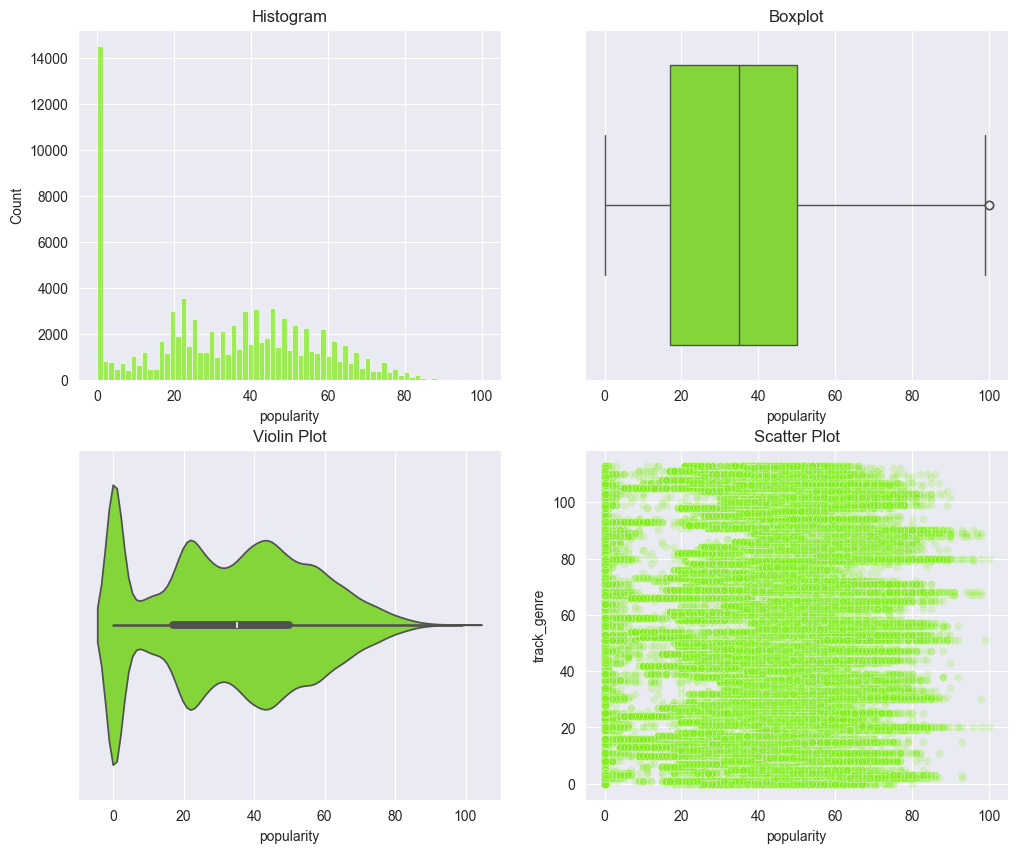

<Figure size 640x480 with 0 Axes>

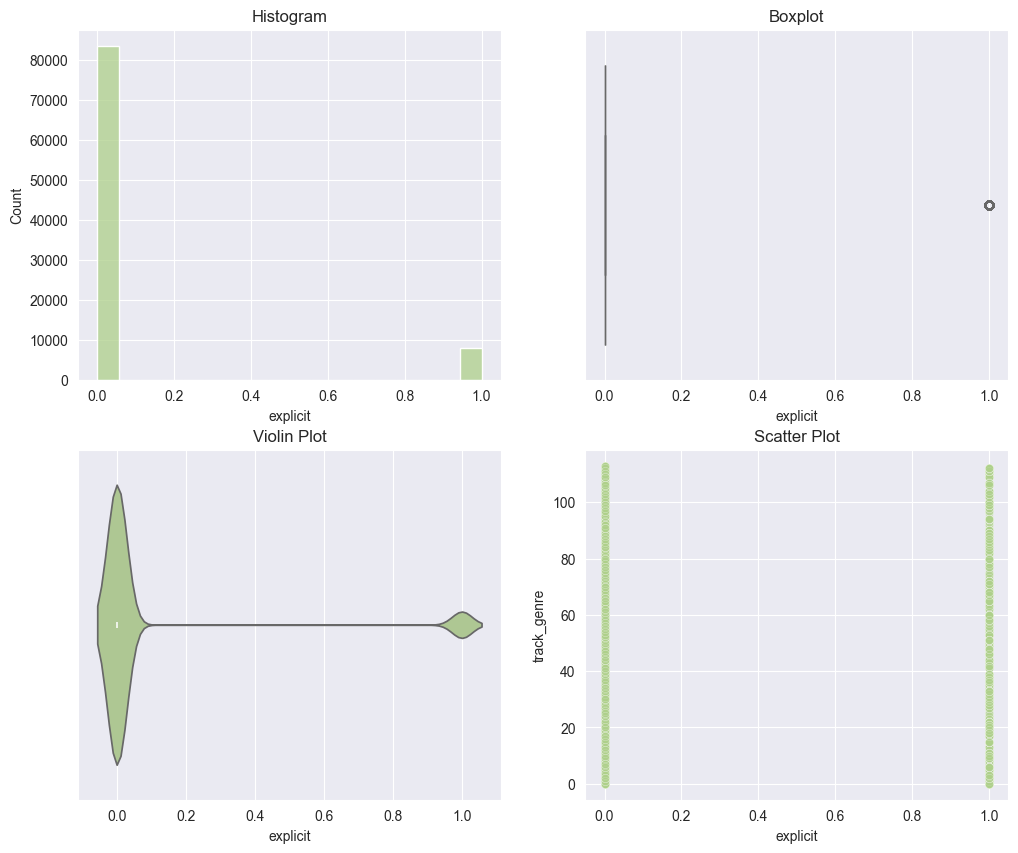

<Figure size 640x480 with 0 Axes>

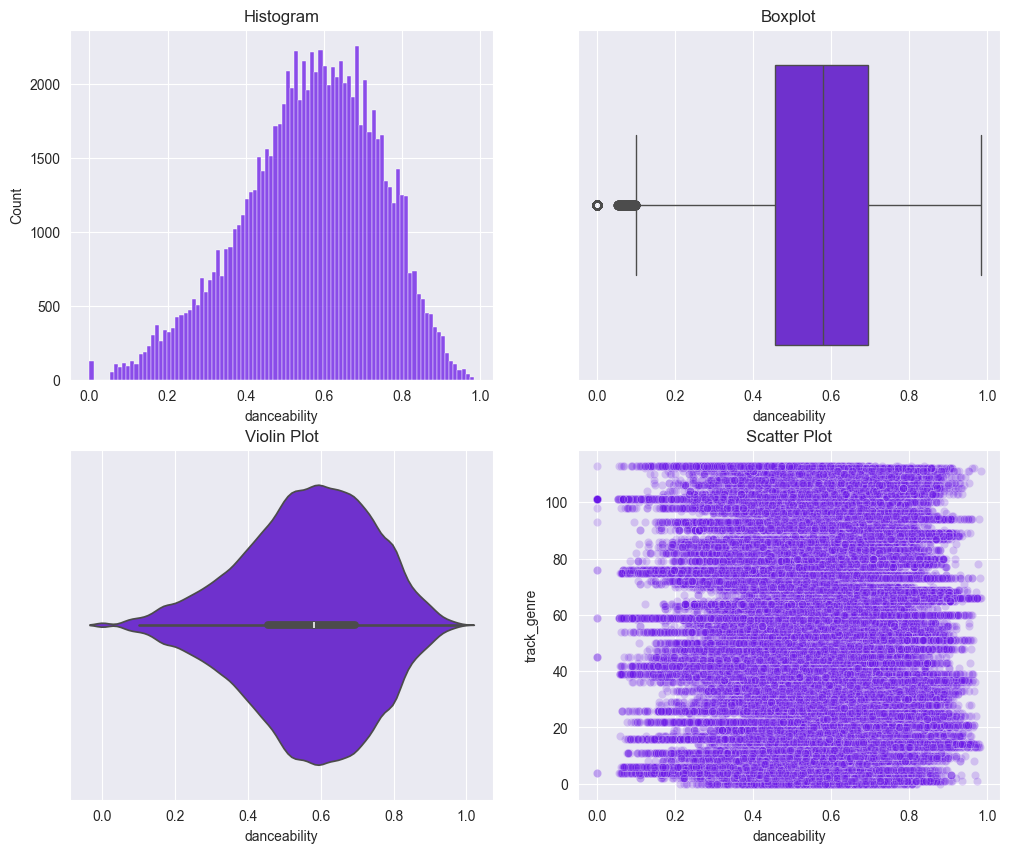

<Figure size 640x480 with 0 Axes>

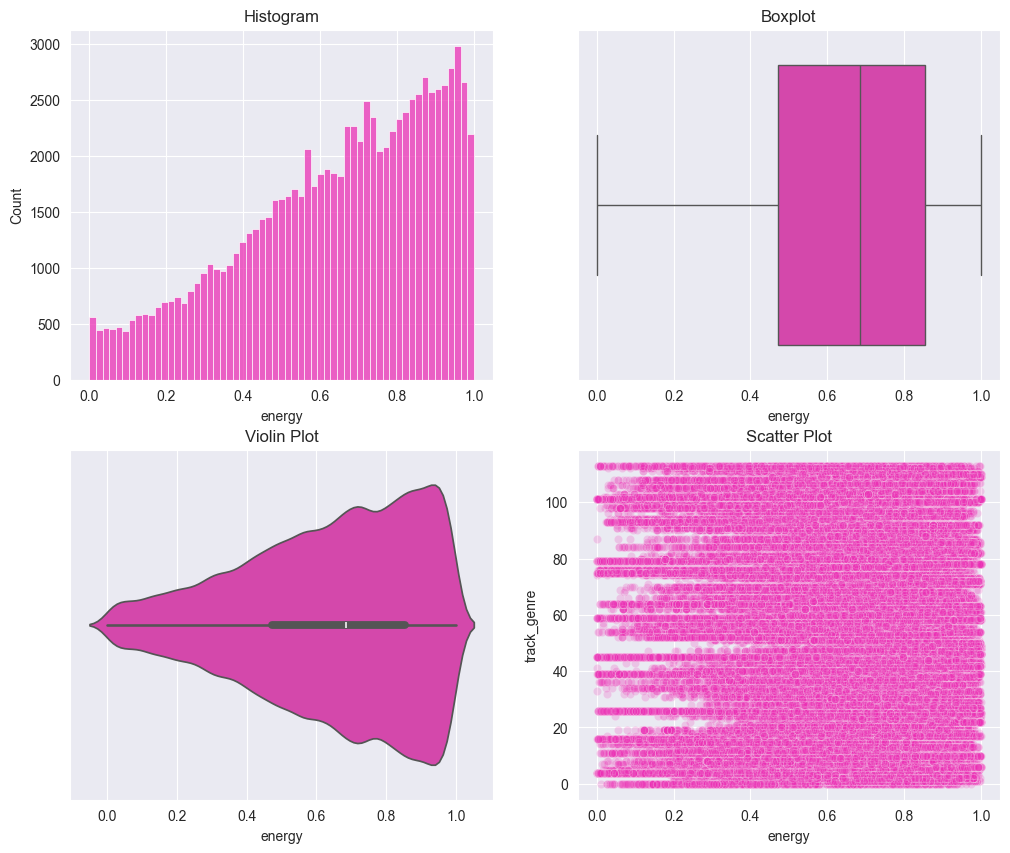

<Figure size 640x480 with 0 Axes>

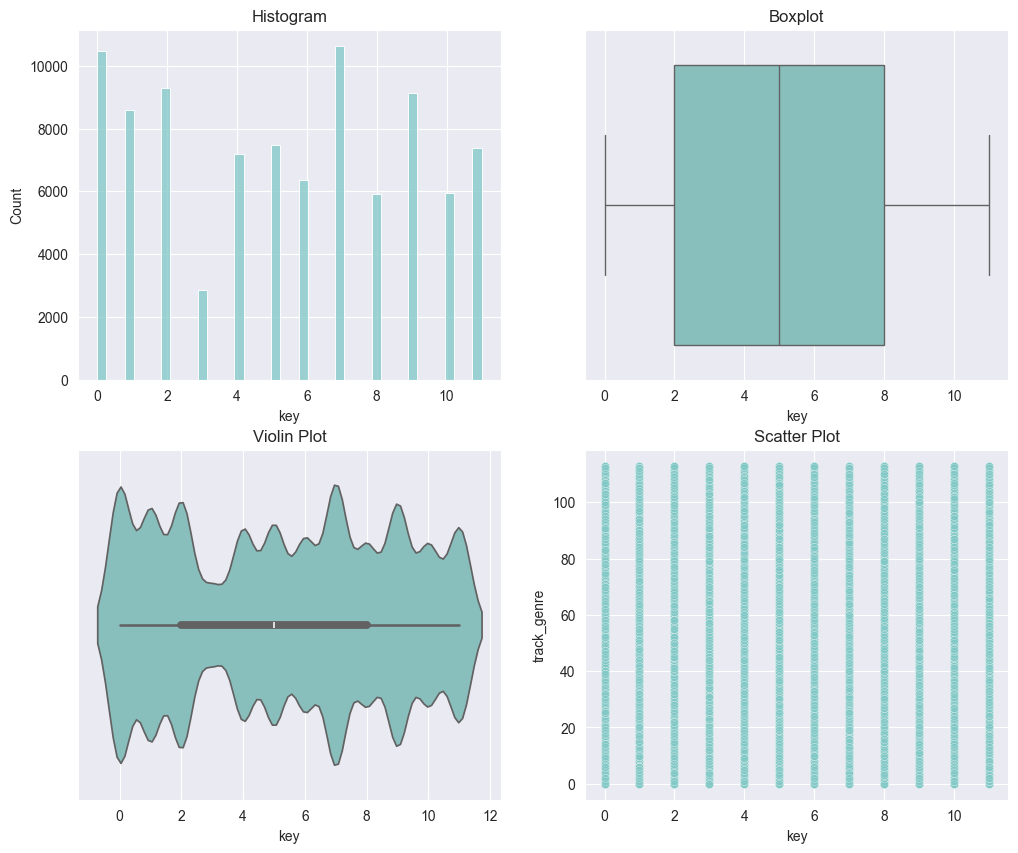

<Figure size 640x480 with 0 Axes>

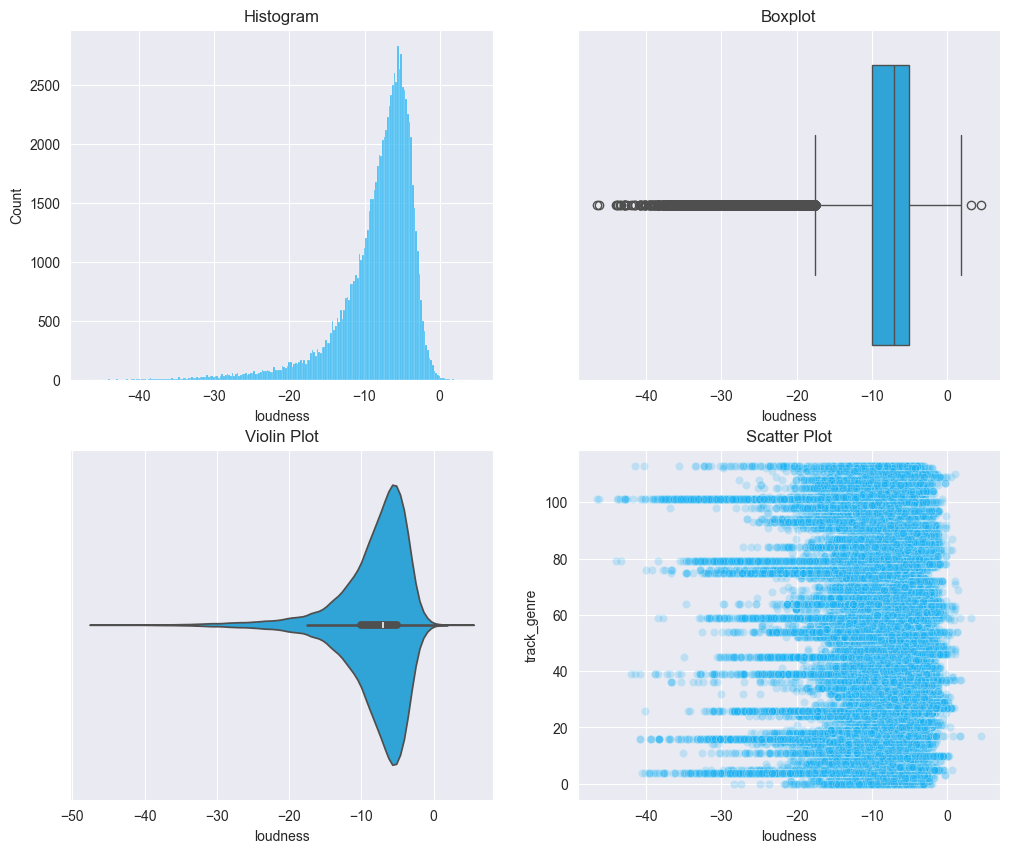

<Figure size 640x480 with 0 Axes>

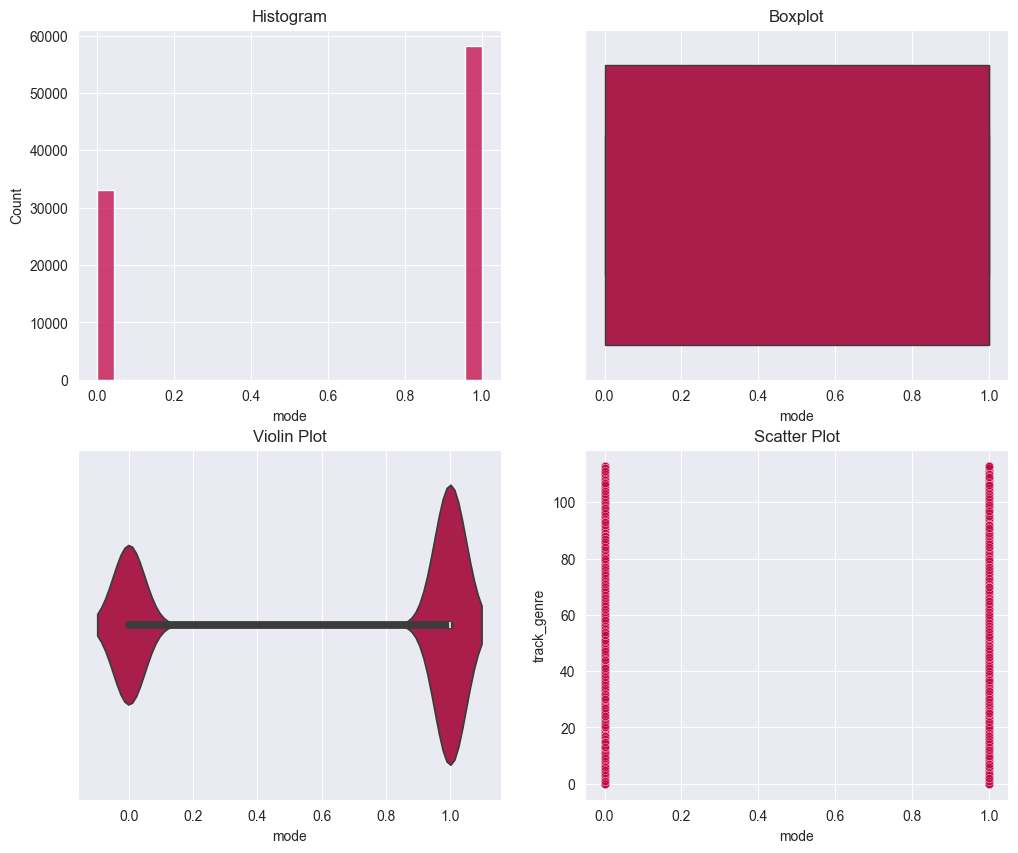

<Figure size 640x480 with 0 Axes>

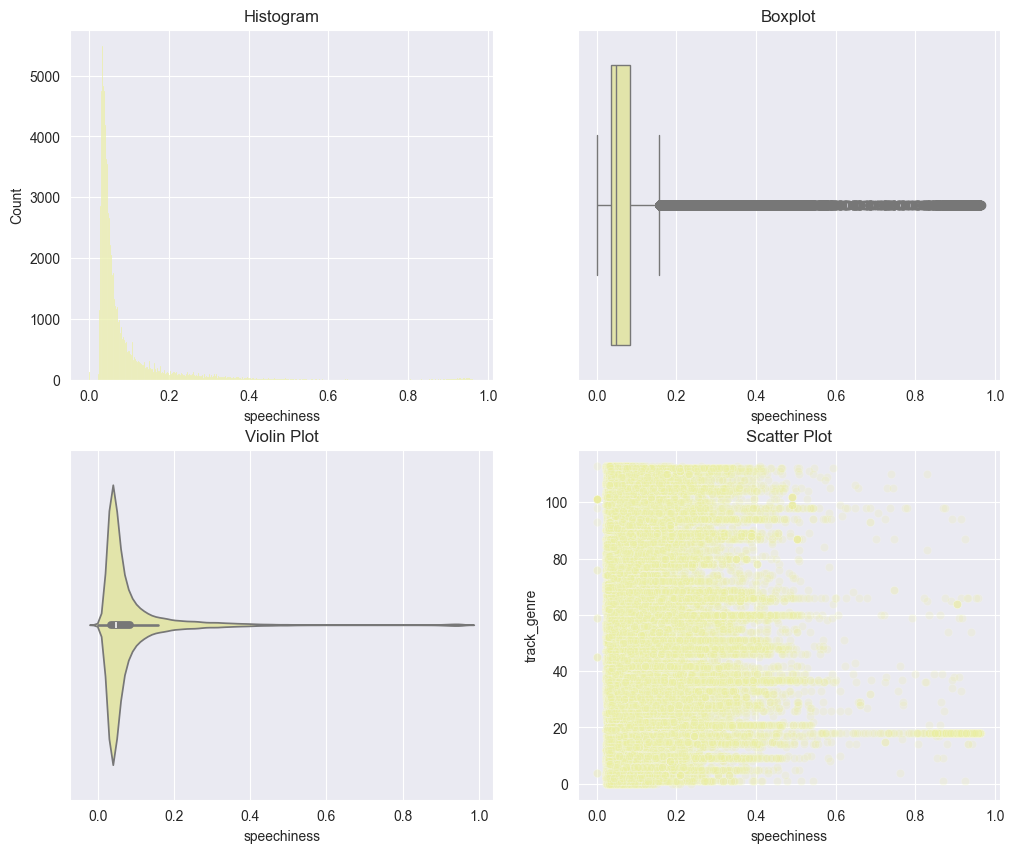

<Figure size 640x480 with 0 Axes>

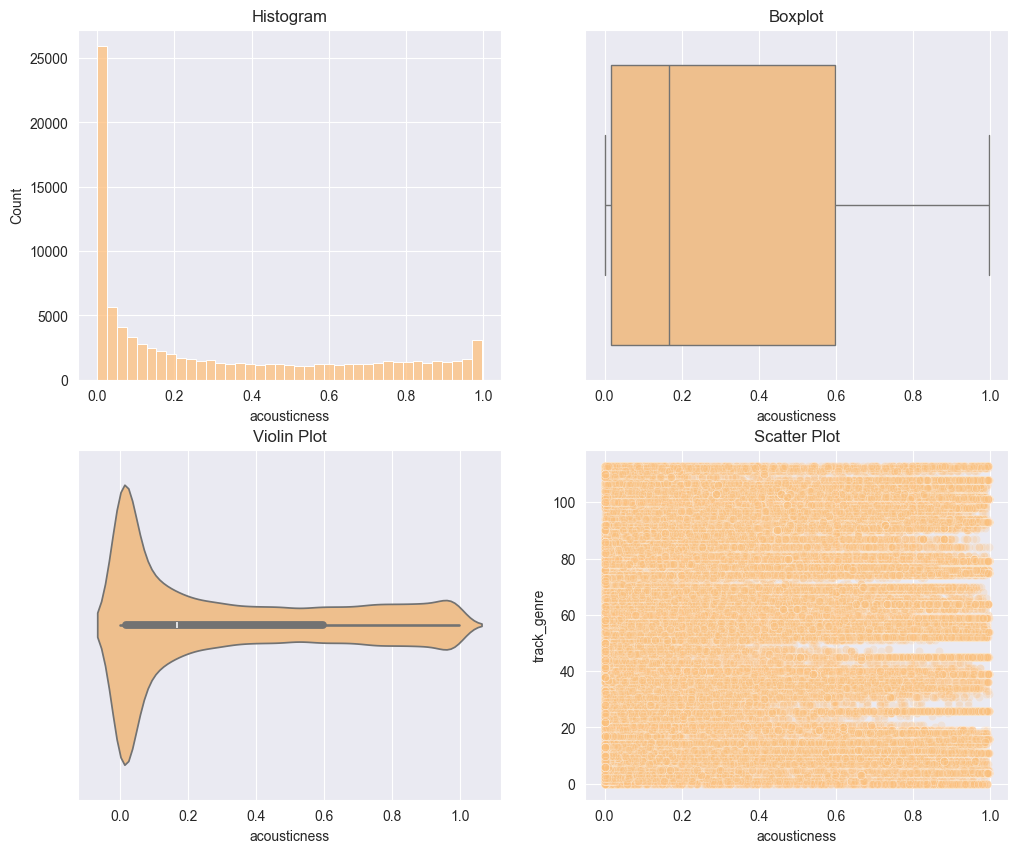

<Figure size 640x480 with 0 Axes>

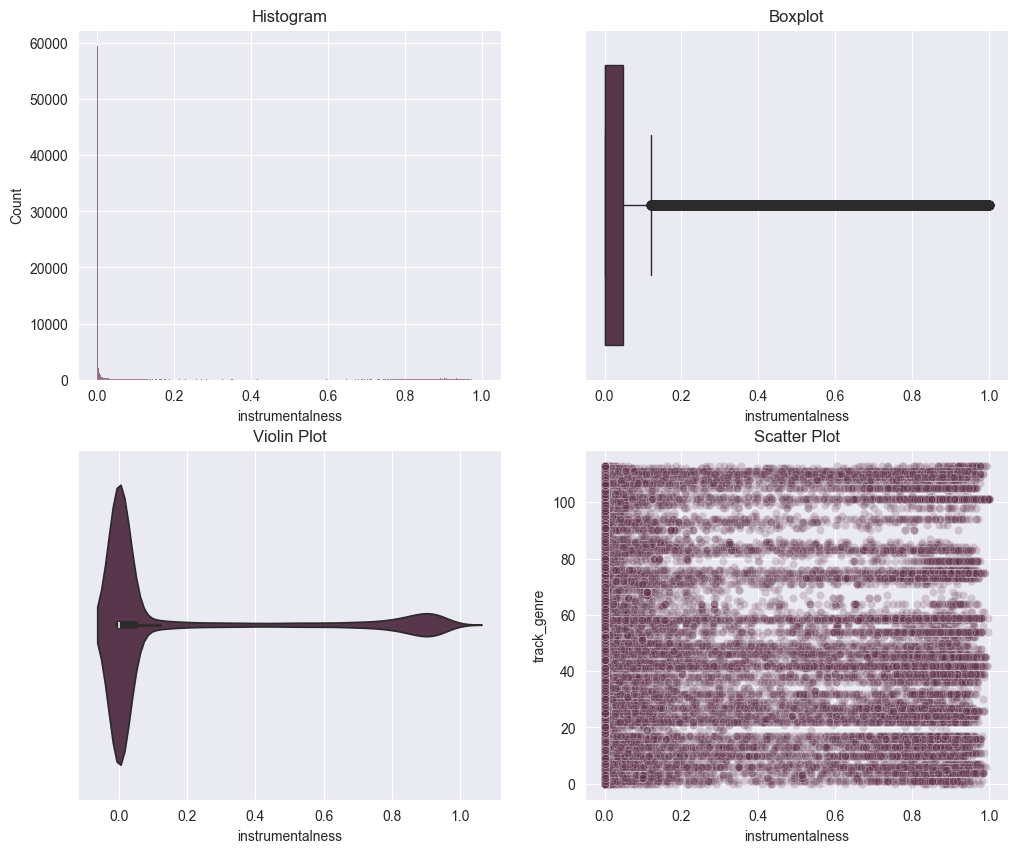

<Figure size 640x480 with 0 Axes>

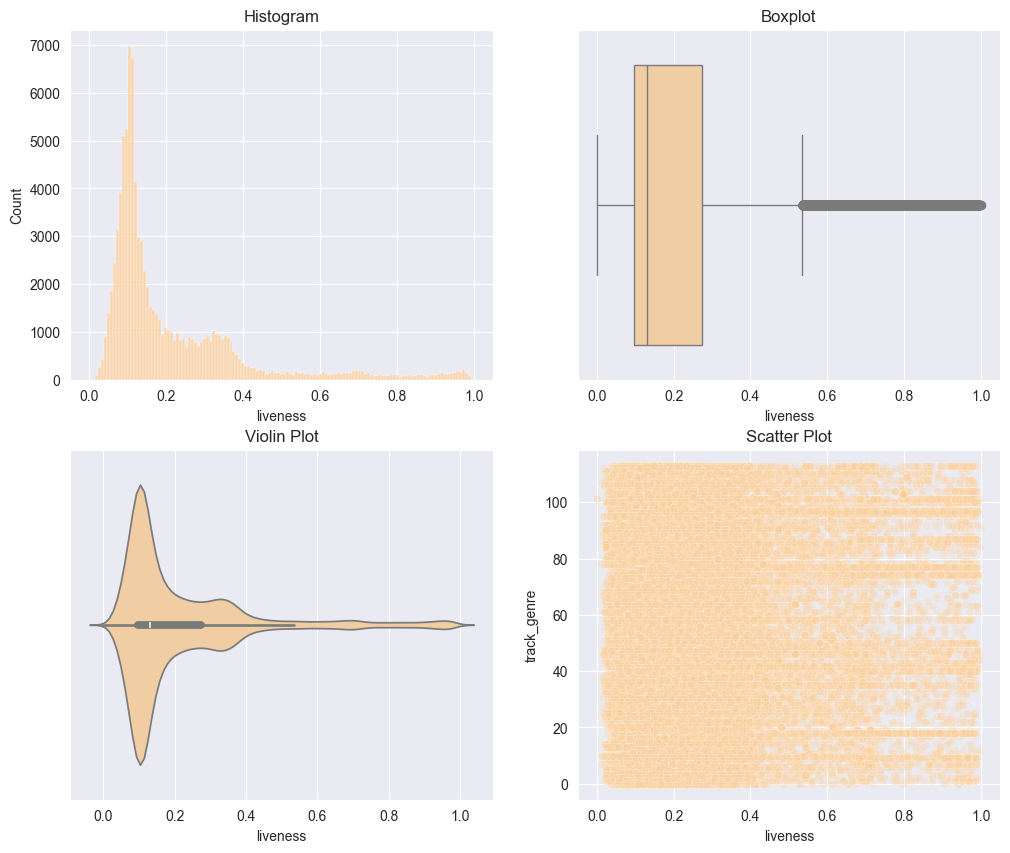

<Figure size 640x480 with 0 Axes>

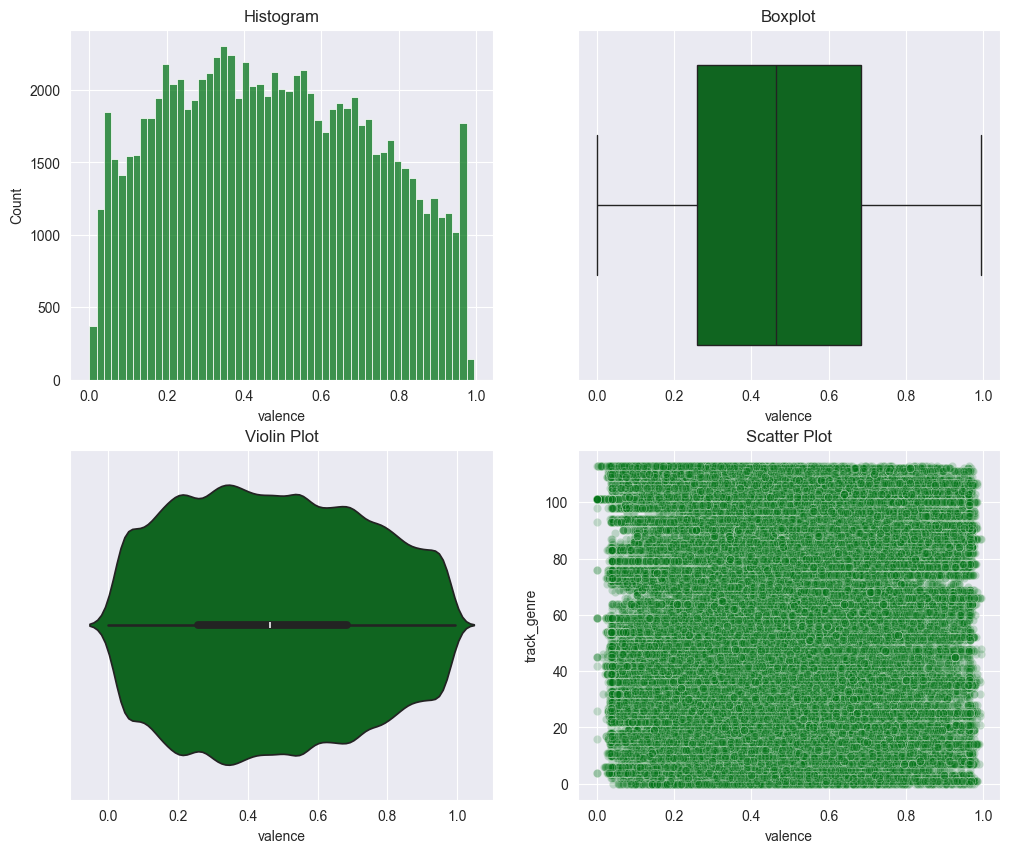

<Figure size 640x480 with 0 Axes>

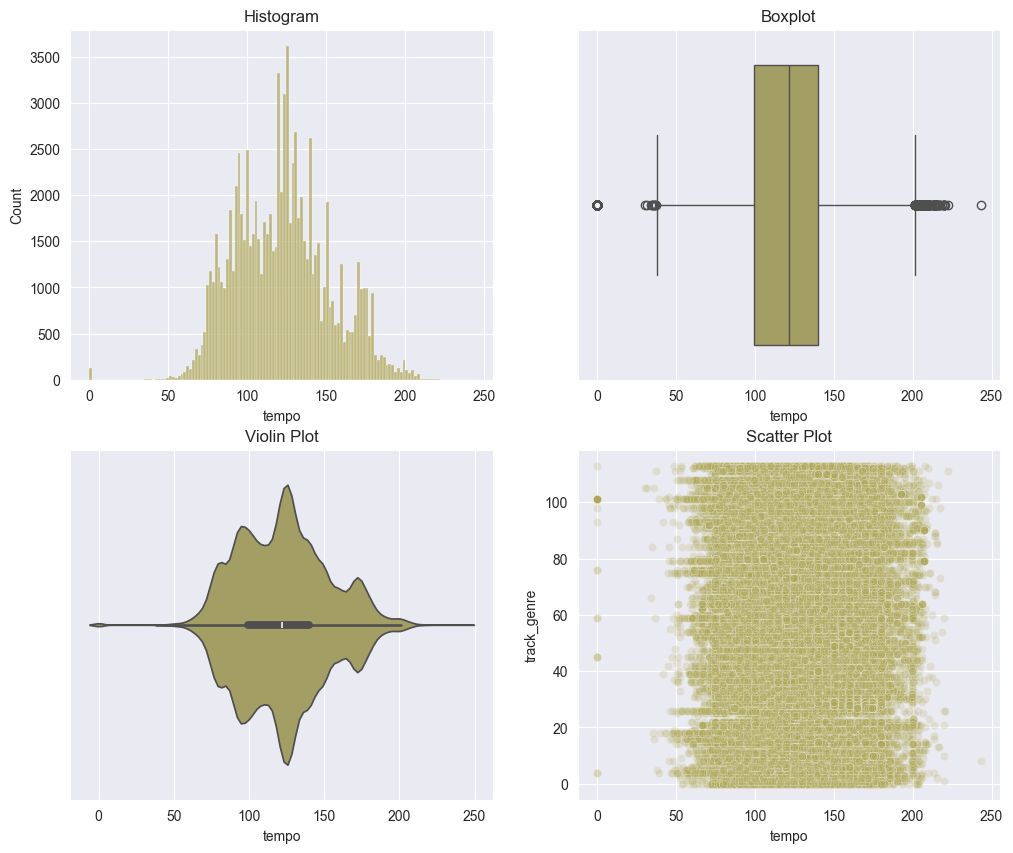

<Figure size 640x480 with 0 Axes>

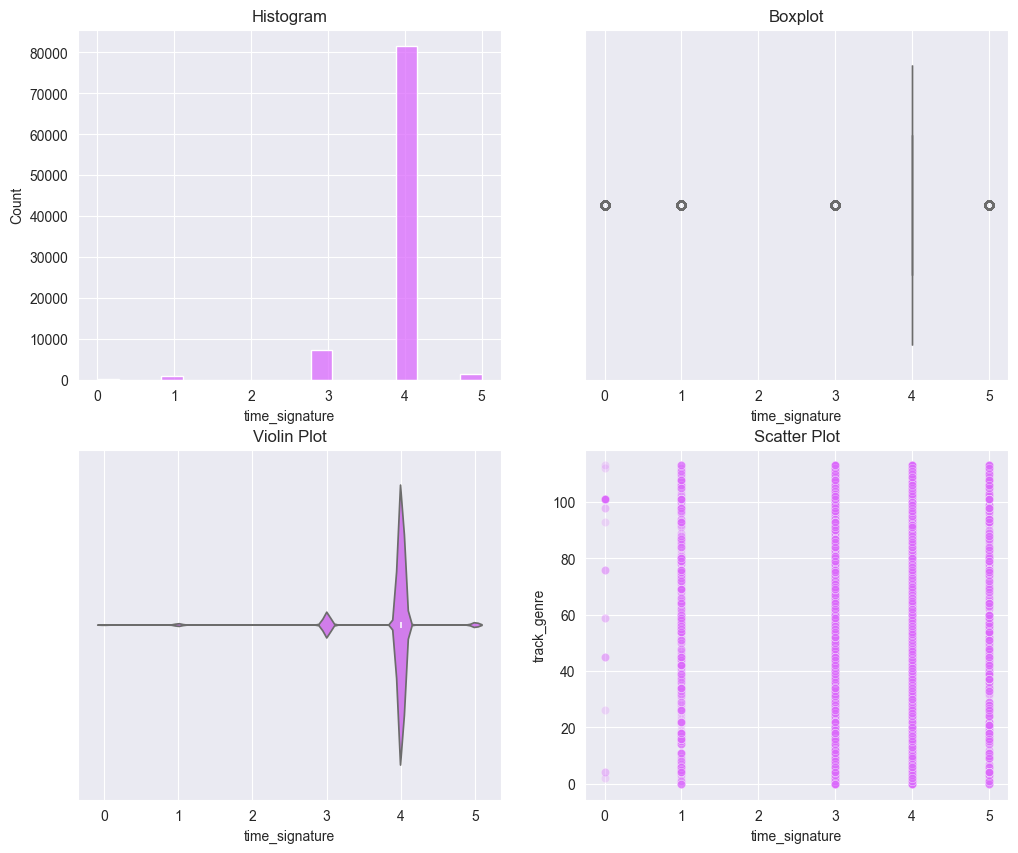

<Figure size 640x480 with 0 Axes>

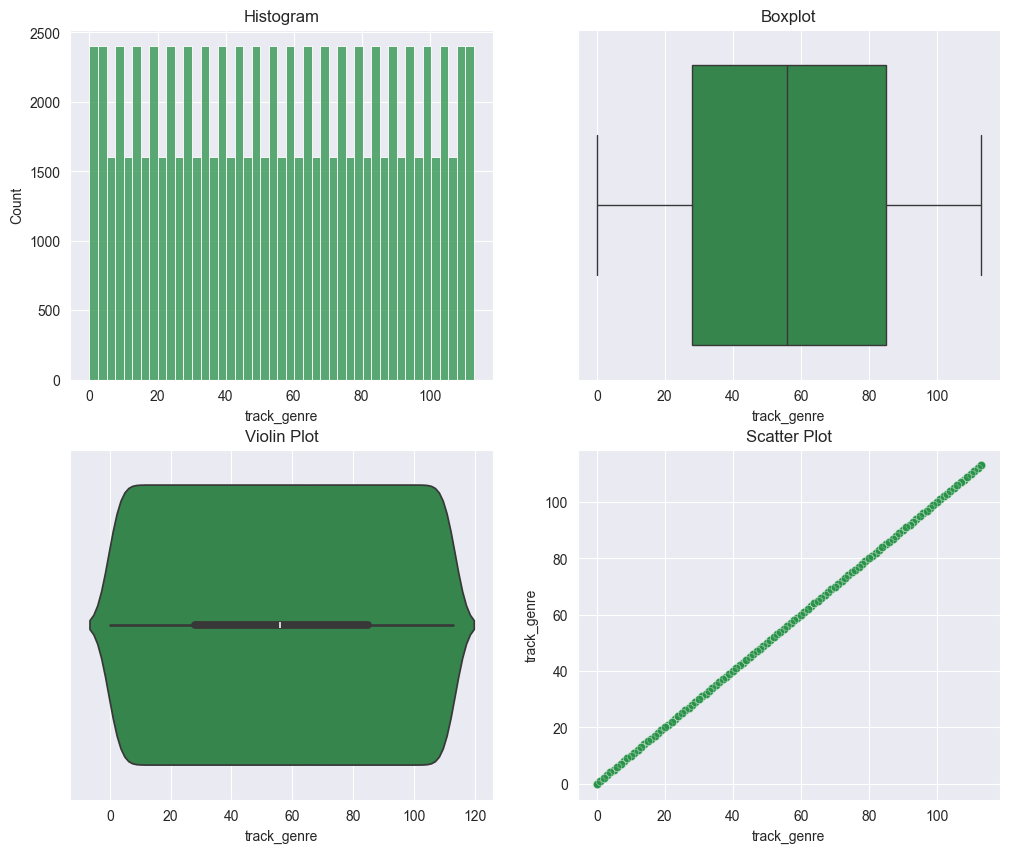

<Figure size 640x480 with 0 Axes>

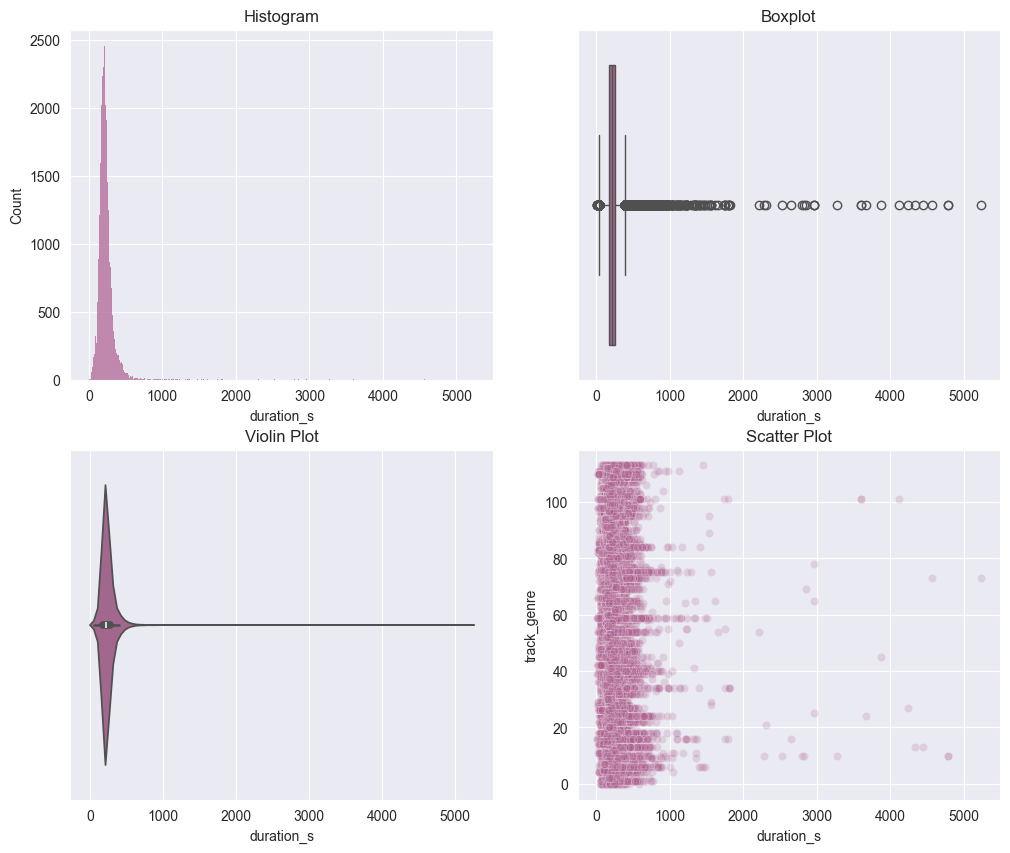

In [54]:
def visualize_attribute(train: pd.DataFrame, attribute: str) -> None:
    plt.figure(facecolor='darkblue')
    color = np.random.rand(3,)
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    sns.histplot(data=train, x=attribute, kde=False, ax=axes[0, 0], color=color)
    axes[0, 0].set_title('Histogram')
    
    sns.boxplot(data=train, x=attribute, ax=axes[0, 1], color=color)
    axes[0, 1].set_title('Boxplot')
    
    sns.violinplot(data=train, x=attribute, ax=axes[1, 0], color=color)
    axes[1, 0].set_title('Violin Plot')
    
    sns.scatterplot(data=train, x=attribute, y='track_genre', ax=axes[1, 1], color=color, alpha=0.2)
    axes[1, 1].set_title('Scatter Plot')
    
    plt.show()

attributes = list(train.keys())
for attribute in attributes:
    visualize_attribute(train, attribute)

**Prvi zaključci**
- Pesme sa većem brojem izvođača uglavnom pripadaju žanrovima sa višim indeksom
- Takođe pesme sa dužim imenima albuma češće pripadaju žanrovima sa višim indeksom
- Pesme trajanja iznad 2*10e6 ms su retke ali zastupljene među svim žanrovima
- Pesme sa više teksta obično pripadaju žanrovima sa indeksom oko 20
- Pesme sa sporijim ritmom su retke, zastupljene u svim žanrovima ali najviše kod žanrova sa višim indeksom

## Normalizacija atributa

In [55]:
def transform_skewed_attributes(train, transf_map:dict = {}, skew_threshold=0.1):
    transformer = PowerTransformer(method='yeo-johnson')
    train_cp = train.copy()
    for column in train_cp.columns:
        if train_cp[column].dtype in [np.float64, np.int64]:
            skewness = train_cp[column].skew()
            if abs(skewness) > skew_threshold:
                transformer = PowerTransformer(method='yeo-johnson')
                transformer = transformer.fit(train_cp[[column]])
                train_cp[column] = transformer.transform(train_cp[[column]])
                if column in transf_map.keys():
                    transf_map[column].append(transformer)
                else:
                    transf_map[column] = [transformer]

    return train_cp

def scale(train, transf_map:dict = {}):
    train_cp = train.copy()
    for column in train.columns:
        if train_cp[column].dtype in [np.float64, np.int64]:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler = scaler.fit(train_cp[[column]])
            train_cp[column] = scaler.transform(train_cp[[column]])
            if column in transf_map.keys():
                    transf_map[column].append(scaler)
            else:
                transf_map[column] = [scaler]
    return train_cp

def apply_transf(X, transf_map:dict):
    result = X.copy()
    for attribute in transf_map.keys():
        for tr in transf_map[attribute]:
            result[attribute] = tr.transform(result[[attribute]])
    return result

# Trening

In [56]:
def train_test_model(X, y, model, param_grid, result_df, tag=None):
    # Ensure y is a 1D array of class labels
    train_y = y.values.ravel()  # Flatten y to be a 1D array
    
    # Define the custom scorer for multi-class ROC AUC
    f1_scorer = make_scorer(f1_score, average='macro')


    # Perform hyperparameter tuning using HalvingGridSearchCV
    halving_search = RandomizedSearchCV(model, param_grid, scoring=f1_scorer, n_jobs=4, cv=2, verbose=1, n_iter = 70)
    halving_search.fit(X, train_y)
    
    # Get the best model
    best_model = halving_search.best_estimator_
    
    # Predict on the entire dataset
    y_pred = best_model.predict(X)
    
    # Calculate evaluation metrics
    # For ROC AUC, it requires probabilities
    if hasattr(best_model, 'predict_proba'):
        y_pred_prob = best_model.predict_proba(X)
        auc = roc_auc_score(train_y, y_pred_prob, multi_class='ovr')
    else:
        auc = np.nan
    
    f1 = f1_score(train_y, y_pred, average='macro')
    precision = precision_score(train_y, y_pred, average='macro')
    recall = recall_score(train_y, y_pred, average='macro')

    
    # Print results
    print(f"Model: {type(model).__name__}")
    print(f"AUC: {auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Best Params: {halving_search.best_params_}")
    
    # Store results in the results dataframe
    tag = "_" + tag if tag is not None else ""
    results = pd.DataFrame([{
        'Model': type(model).__name__ + tag,
        'AUC': auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Best Params': halving_search.best_params_
    }])
    result_df = pd.concat([result_df, results], ignore_index=True)
    
    # Visualizing the results
    
    # Confusion matrix
    cm = confusion_matrix(train_y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    # Feature importance (if applicable)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(X.shape[1]), importances[indices], color='r', align='center')
        if X is pd.DataFrame:
            plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        else:
            plt.xticks(range(X.shape[1]), indices, rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    
    print(results)
    return best_model, result_df

def apply_transf_list(data, transforms):
    d = data.copy()
    for t in transforms:
        d = t(d)
        if t is PCA:
            d = pd.DataFrame(d, columns=[f'PC{i+1}' for i in range(d.shape[1])])
    return d

def test_model(X, y, model):
    test_y = y.values.ravel()
    
    y_pred = model.predict(X)
    
    if hasattr(model, 'predict_proba'):
        y_pred_prob = model.predict_proba(X)
        auc = roc_auc_score(test_y, y_pred_prob, multi_class='ovr')
    else:
        auc = np.nan
    
    f1 = f1_score(test_y, y_pred, average='macro')
    precision = precision_score(test_y, y_pred, average='macro')
    recall = recall_score(test_y, y_pred, average='macro')

    print(f"Model: {type(model).__name__}")
    print(f"AUC: {auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    results = pd.DataFrame([{
        'Model': type(model).__name__,
        'AUC': auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
    }])
    cm = confusion_matrix(test_y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    print(results)


In [57]:
ss = scale
norm = transform_skewed_attributes
pca = PCA(n_components=0.97)
transforms = [('None',[]), ('PCA',[pca.fit_transform])]

In [58]:
models = []
#Koristio sam ove modele jer su bazirani na stablima odlucivanja a donose bolje rezulate
models.append((RandomForestClassifier, {
    'n_estimators': [300, 500],           
    'max_depth': [None, 5, 7],                    
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]                           
}))
models.append((AdaBoostClassifier, {
    'n_estimators': [100, 150, 250],  
    'learning_rate': [0.01, 0.1, 1.0],  
    'estimator': [
        DecisionTreeClassifier(max_depth=5),
        DecisionTreeClassifier(max_depth=13),
        DecisionTreeClassifier(max_depth=None)
    ] 
}))
models.append((HistGradientBoostingClassifier, {
    'learning_rate': [0.01, 0.05, 0.1],         
    'max_iter': [200, 300],                     
    'max_leaf_nodes': [15, 31, 63],                  
    'max_depth': [5, 7],                          
    'min_samples_leaf': [10, 20, 30],                
    'max_bins': [255, 510],                         
    'l2_regularization': [0, 0.1, 1],                
    'early_stopping': [True, False]                  
}))
models.append((ExtraTreesClassifier, {
    'n_estimators': [ 300, 500],
    'max_depth': [None, 5, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True]
}))

In [59]:
y = train['track_genre']
train.drop(['track_genre'],inplace=True, axis=1)

C:\Users\Danilo\AppData\Local\Temp\ipykernel_11588\3109662194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['track_genre'],inplace=True, axis=1)


In [60]:
train.isna().sum()

artists             0
album_name          0
track_name          0
popularity          0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
duration_s          0
dtype: int64

In [61]:
results = pd.DataFrame()
best_models = []

In [ ]:
tag, transform_list = transforms[0]
model, grid = models[0]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
#Pokrenuto
tag, transform_list = transforms[1]
model, grid = models[0]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[0]
model, grid = models[1]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[1]
model, grid = models[1]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[0]
model, grid = models[2]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[1]
model, grid = models[2]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
results

Najbolji rezultati su za:

- **Model: RandomForestClassifier**
- AUC: 0.9991
- F1: 0.8262
- Precision: 0.8262
- Recall: 0.8265
- Best Params: {'n_estimators': 300, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
- **BEZ PCA**

In [62]:
# Pokretanjem se dobija ovaj model kao jedan od najboljih tako da je on izabran
# Nakon pokretanja je program crash-ovao zbog nedostatka memorije 
best_model = RandomForestClassifier(n_estimators=300, max_features='log2', max_depth=None, bootstrap=True)
best_model.fit(train, y.values.ravel())

RandomForestClassifier(max_features='log2', n_estimators=300)

# Test

In [63]:
test

artists  album_name  track_name  popularity  explicit  danceability  \
14677         1          12           8          30         0      0.600098   
23232         3          12          12          46         0      0.645020   
16103         3          19           9          45         0      0.603027   
95015         1          12           6           0         0      0.655762   
66024         2          16          36          29         0      0.689941   
...         ...         ...         ...         ...       ...           ...   
111313        1          28          49          54         0      0.820801   
107154        1           4           4          48         0      0.754883   
111739        1          20          14          18         0      0.619141   
29842         1          21           9          46         0      0.519043   
40841         1          11          14          39         0      0.493896   

          energy  key   loudness  mode  speechiness  acousticness  \
14677   0.135010    2 -15.375000     1     0.033508      0.983887   
23232   0.673828    8  -7.261719     0     0.026794      0.028900   
16103   0.743164    9  -7.011719     1     0.055298      0.728027   
95015   0.852051    5  -4.855469     0     0.035889      0.396973   
66024   0.687988    3  -7.992188     0     0.156006      0.031311   
...          ...  ...        ...   ...          ...           ...   
111313  0.527832    4 -11.750000     0     0.046295      0.117004   
107154  0.693848    8  -5.359375     1     0.042389      0.204956   
111739  0.622070    5  -9.250000     0     0.046814      0.074219   
29842   0.908203   10  -1.347656     0     0.111023      0.151001   
40841   0.525879    4  -5.796875     1     0.027405      0.750000   

        instrumentalness  liveness   valence     tempo  time_signature  \
14677           0.023895  0.111023  0.068787  128.7500               4   
23232           0.022293  0.111023  0.350098  124.0625               4   
16103           0.000042  0.103027  0.341064  100.0000               4   
95015           0.000053  0.083374  0.801758  165.1250               4   
66024           0.000020  0.101013  0.793945  203.6250               4   
...                  ...       ...       ...       ...             ...   
111313          0.070190  0.081604  0.344971   92.1250               4   
107154          0.000823  0.273926  0.530762  120.0625               4   
111739          0.623047  0.521973  0.173950  172.1250               4   
29842           0.019302  0.098511  0.089417   75.1250               4   
40841           0.000000  0.099792  0.177979  130.1250               4   

        track_genre  duration_s  
14677            14     193.125  
23232            23     190.625  
16103            16     269.750  
95015            95     296.000  
66024            66     254.125  
...             ...         ...  
111313          111     249.375  
107154          107     210.750  
111739          111     331.750  
29842            29     232.000  
40841            40     297.500  

[22800 rows x 19 columns]

In [64]:
y = test['track_genre']
test.drop(['track_genre'],inplace=True, axis=1)

C:\Users\Danilo\AppData\Local\Temp\ipykernel_11588\4283961432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['track_genre'],inplace=True, axis=1)


Model: RandomForestClassifier
AUC: 0.9227
F1: 0.3454
Precision: 0.3449
Recall: 0.3546


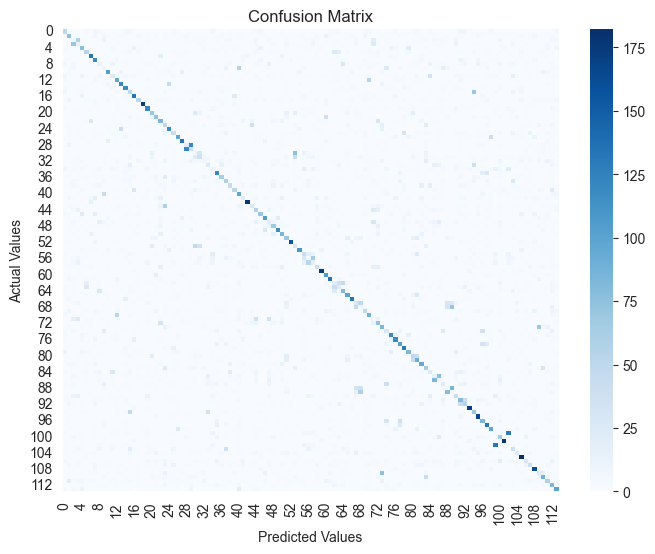

                    Model      AUC        F1  Precision    Recall
0  RandomForestClassifier  0.92267  0.345395   0.344915  0.354561


In [65]:
test_model(test, y, best_model)